In [1]:
from __future__ import division
from neuron import h
from neuron import gui
import matplotlib.pyplot as plt
import numpy as np
plt.ion()


## Build ball and stick model ##


In [2]:
v_rest = -60 # the baseline voltage.

soma = h.Section(name="soma")
soma.L    = 25
soma.diam = 25
soma.Ra   = 100
soma.insert('pas')
soma.g_pas = 1/20000
soma.e_pas = v_rest # the reversal of the passive channels

soma.insert('na') # insert active conductances to the soma.
soma.gbar_na = 5000 # set the Na conductance
soma.insert('kv')
soma.gbar_kv = 1500 # set the K conductance
h.celsius = 30


dend = h.Section(name="dend")
dend.L    = 700  
dend.diam = 1    
dend.Ra   = 100 
dend.insert('pas')
dend.e_pas = v_rest
dend.g_pas = 1/20000

dend.connect(soma, 1, 0)  #connect the end of the soma to the start of the dendrite

# set number of segement
h("forall { nseg = int((L/(0.1*lambda_f(100))+0.9)/2)*2 + 1  }")
h.define_shape()

1.0


## Set up synapses


In [3]:
#We create 20 AMPA_NMDA synapses:
hotspot_NMDA_synapses = []
hotspot_NMDA_netcons  = []
hotspot_NMDA_netstims = []
for j in range(20):
    hotspot_NMDA_synapses.append(h.ProbAMPANMDA2_RATIO(dend(0.6)))
    hotspot_NMDA_netstims.append(h.NetStim(dend(0.5)))
    hotspot_NMDA_netcons.append(h.NetCon(hotspot_NMDA_netstims[j], hotspot_NMDA_synapses[j]))

    hotspot_NMDA_synapses[j].tau_r_AMPA = 0.33 # AMPA rise time
    hotspot_NMDA_synapses[j].tau_d_AMPA = 1    # AMPA decay time
    hotspot_NMDA_synapses[j].e=0
    hotspot_NMDA_synapses[j].tau_r_NMDA = 0.23 # NMDA rise time
    hotspot_NMDA_synapses[j].tau_d_NMDA = 55   # NMDA decay time


    hotspot_NMDA_netcons[j].weight[0]= 0.5 # strength of the synapse

    hotspot_NMDA_netstims[j].number   = 9e9 # number of synaptic activation
    hotspot_NMDA_netstims[j].noise    = 1   # randomness
    hotspot_NMDA_netstims[j].interval = 50  # mean time between spikes |50 ms = 20 Hz|

#create one inhibitory synapse at location 0.2
on_path_inhibition = h.Exp2Syn(dend(0.2)) 
on_path_inhibition.tau1 = 0.01 # synapse rise time
on_path_inhibition.tau2 = 9e9  # synapse decay time
on_path_inhibition.e    = v_rest

#create one inhibitory synapse at location 0.99
off_path_inhibition  = h.Exp2Syn(dend(0.99))
off_path_inhibition.tau1 = 0.01
off_path_inhibition.tau2 = 9e9
off_path_inhibition.e    = v_rest

#create a NetStim that will activate the synapses  at t=1000
inhibition_netstim = h.NetStim(dend(0.5))
inhibition_netstim.number = 1   # number of synaptic activation
inhibition_netstim.start = 1000 # activation start time
inhibition_netstim.noise = 0    # randomness
on_path_netcon  = h.NetCon(inhibition_netstim, on_path_inhibition)
off_path_netcon = h.NetCon(inhibition_netstim, off_path_inhibition)

## set up recording

In [4]:
soma_v = h.Vector()  # set up a recording vector
soma_v.record(soma(0.5)._ref_v)  # record voltage at the middle of the soma

# Record voltage from all segments in the dendrite
dend_vs = []
for seg in dend:
    dend_vs.append(h.Vector())
    dend_vs[-1].record(seg._ref_v)

t = h.Vector()
t.record(h._ref_t)  #record time.
h.v_init = v_rest  # set starting voltage 
h.tstop = 5000  # set simulation time

## Run simulation 

In [5]:

# Run simulation with proximal inhibition #
##
inhibition_weight = 0.0045

on_path_netcon.weight[0]  = inhibition_weight # activate the on_path synapse 
off_path_netcon.weight[0] = 0 # deactivate the off path synapse by changing its conductance to 0 
h.run()
soma_v_proximal_inh = list(soma_v)


# Run simulation with distal inhibition  #
##
on_path_netcon.weight[0]  = 0 # deactivate the on path synapse by changing its conductance to 0 
off_path_netcon.weight[0] = inhibition_weight # activate only the on_path synapse 
h.run()
soma_v_distal_inh = list(soma_v)

## Plot Results

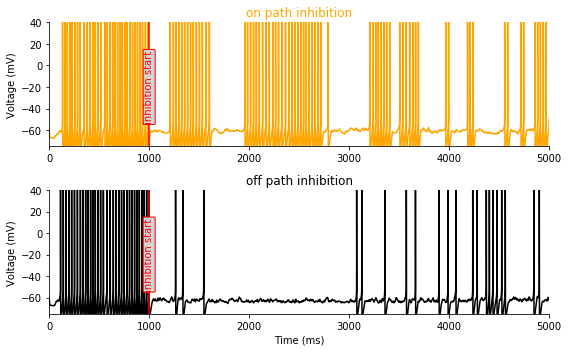

In [6]:
plt.figure(figsize=(8,5))
ax = plt.subplot(2,1,1)
plt.plot(t, soma_v_proximal_inh,color='orange',label='on path\ninhibition')
plt.plot([1000,1000], [-75,40], 'red')
plt.text(950,-20,'inhibition start',color='red',rotation=90,va='center', bbox=dict(facecolor='lightgray', edgecolor='red',pad=0.5, boxstyle='round,pad=0.1'))
plt.ylabel('Voltage (mV)')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.title('on path inhibition', color='orange')

ax1 = plt.subplot(2,1,2,sharex=ax,sharey=ax)
plt.plot(t, soma_v_distal_inh,color='black',label='off path\ninhibition')
plt.plot([1000,1000], [-75,40], 'red')
plt.text(950,-20,'inhibition start',color='red',rotation=90,va='center', bbox=dict(facecolor='lightgray', edgecolor='red',pad=0.5,boxstyle='round,pad=0.1'))
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('off path inhibition', color='black')
plt.xlim(0,5000)
plt.ylim(-75,40)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.tight_layout()